In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import kmapper as km

from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV

sns.set_style('darkgrid')

## Load extracted features

In [2]:
DATASET_NAME = "large_class_ds"
FIGURES = "./figures"

In [3]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict'}

In [4]:
# Load code vectors and labels
df = pd.read_json(f'./data/{DATASET_NAME}/features.json', lines=True)
df

,label,assignment_probability,assignment_feature,cluster_label
0,save,"[0.000438190181739, 0.001162145170383, -0.0044...","[-0.9703267216682431, -0.9710254073143001, -0....",1
1,train,"[-6.51636000839062e-05, 1.2758993761963213e-05...","[0.9797478914260861, 0.9803113937377931, 0.980...",3
2,<unk>,"[5.765929017798044e-06, 5.299213080434128e-05,...","[0.9625115394592281, 0.96363341808319, 0.96366...",3
3,<unk>,"[6.540037429658696e-05, 0.000134114045067, 0.0...","[0.9878452420234681, 0.9884722232818601, 0.988...",3
4,<unk>,"[-0.00023987970780500002, 0.000207815188332, 0...","[0.9858987927436821, 0.9869312047958371, 0.986...",3
...,...,...,...,...
3198,forward,"[-0.00016098550986400002, -0.00046363112051000...","[0.8779269456863401, 0.8803002238273621, 0.878...",3
3199,predict,"[0.0006188481347630001, 0.000340495142154, 0.0...","[0.5394715666770931, 0.538790941238403, 0.5417...",2
3200,predict_proba,"[7.282115257112311e-05, -0.000390377012081, 0....","[0.9497601985931391, 0.950427532196044, 0.9506...",3
3201,load_train_data,"[0.0021989112719890003, 0.002057824051007, -0....","[-0.9575170278549191, -0.9639140963554381, -0....",4


In [5]:
# Drop samples where the target label is unk because we dont know the semantics
df = df.drop(df[df.label == '<unk>'].index)
df

,label,assignment_probability,assignment_feature,cluster_label
0,save,"[0.000438190181739, 0.001162145170383, -0.0044...","[-0.9703267216682431, -0.9710254073143001, -0....",1
1,train,"[-6.51636000839062e-05, 1.2758993761963213e-05...","[0.9797478914260861, 0.9803113937377931, 0.980...",3
6,training_image_uri,"[-9.469770157011227e-05, 1.201393570227082e-05...","[0.8719326257705681, 0.8710832595825191, 0.870...",3
7,create_predictor,"[0.000186584074981, -0.00016554830654000002, 0...","[0.9210784435272211, 0.9212878942489621, 0.921...",3
24,hybrid_forward,"[-0.00027660361956800003, -0.00041252013761500...","[0.909326195716857, 0.910818636417388, 0.90937...",3
...,...,...,...,...
3198,forward,"[-0.00016098550986400002, -0.00046363112051000...","[0.8779269456863401, 0.8803002238273621, 0.878...",3
3199,predict,"[0.0006188481347630001, 0.000340495142154, 0.0...","[0.5394715666770931, 0.538790941238403, 0.5417...",2
3200,predict_proba,"[7.282115257112311e-05, -0.000390377012081, 0....","[0.9497601985931391, 0.950427532196044, 0.9506...",3
3201,load_train_data,"[0.0021989112719890003, 0.002057824051007, -0....","[-0.9575170278549191, -0.9639140963554381, -0....",4


In [6]:
# Assign method name category
df['method_name_category'] = df.label.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
df

,label,assignment_probability,assignment_feature,cluster_label,method_name_category
0,save,"[0.000438190181739, 0.001162145170383, -0.0044...","[-0.9703267216682431, -0.9710254073143001, -0....",1,1
1,train,"[-6.51636000839062e-05, 1.2758993761963213e-05...","[0.9797478914260861, 0.9803113937377931, 0.980...",3,0
6,training_image_uri,"[-9.469770157011227e-05, 1.201393570227082e-05...","[0.8719326257705681, 0.8710832595825191, 0.870...",3,0
7,create_predictor,"[0.000186584074981, -0.00016554830654000002, 0...","[0.9210784435272211, 0.9212878942489621, 0.921...",3,4
24,hybrid_forward,"[-0.00027660361956800003, -0.00041252013761500...","[0.909326195716857, 0.910818636417388, 0.90937...",3,3
...,...,...,...,...,...
3198,forward,"[-0.00016098550986400002, -0.00046363112051000...","[0.8779269456863401, 0.8803002238273621, 0.878...",3,3
3199,predict,"[0.0006188481347630001, 0.000340495142154, 0.0...","[0.5394715666770931, 0.538790941238403, 0.5417...",2,4
3200,predict_proba,"[7.282115257112311e-05, -0.000390377012081, 0....","[0.9497601985931391, 0.950427532196044, 0.9506...",3,4
3201,load_train_data,"[0.0021989112719890003, 0.002057824051007, -0....","[-0.9575170278549191, -0.9639140963554381, -0....",4,0


In [7]:
df = df.groupby('method_name_category').apply(lambda grp: grp.sample(n=100)).reset_index(level=[0, 1], drop=True)
df.groupby('method_name_category').size()

method_name_category
0    100
1    100
2    100
3    100
4    100
dtype: int64

In [8]:
df.groupby('cluster_label').size()

cluster_label
0     15
1     64
2     28
3    387
4      6
dtype: int64

In [9]:
k = df.cluster_label.max() + 1
print(f"Num clusters: {k}")

Num clusters: 5


In [10]:
assignment_probabilities = list(df.assignment_probability.map(np.array))
assignment_features = list(df.assignment_feature.map(np.array))

In [11]:
# Use tSNE & clustering
tsne_ap = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=3000)
tsne_ap_results = tsne_ap.fit_transform(assignment_probabilities)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000303
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.217392
[t-SNE] KL divergence after 3000 iterations: 0.495097


In [32]:
tsne_af = TSNE(n_components=3, verbose=1, perplexity=12, n_iter=3000)
tsne_af_results = tsne_af.fit_transform(assignment_features)

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.004204
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.636208
[t-SNE] KL divergence after 1850 iterations: 0.401603


<IPython.core.display.Javascript object>


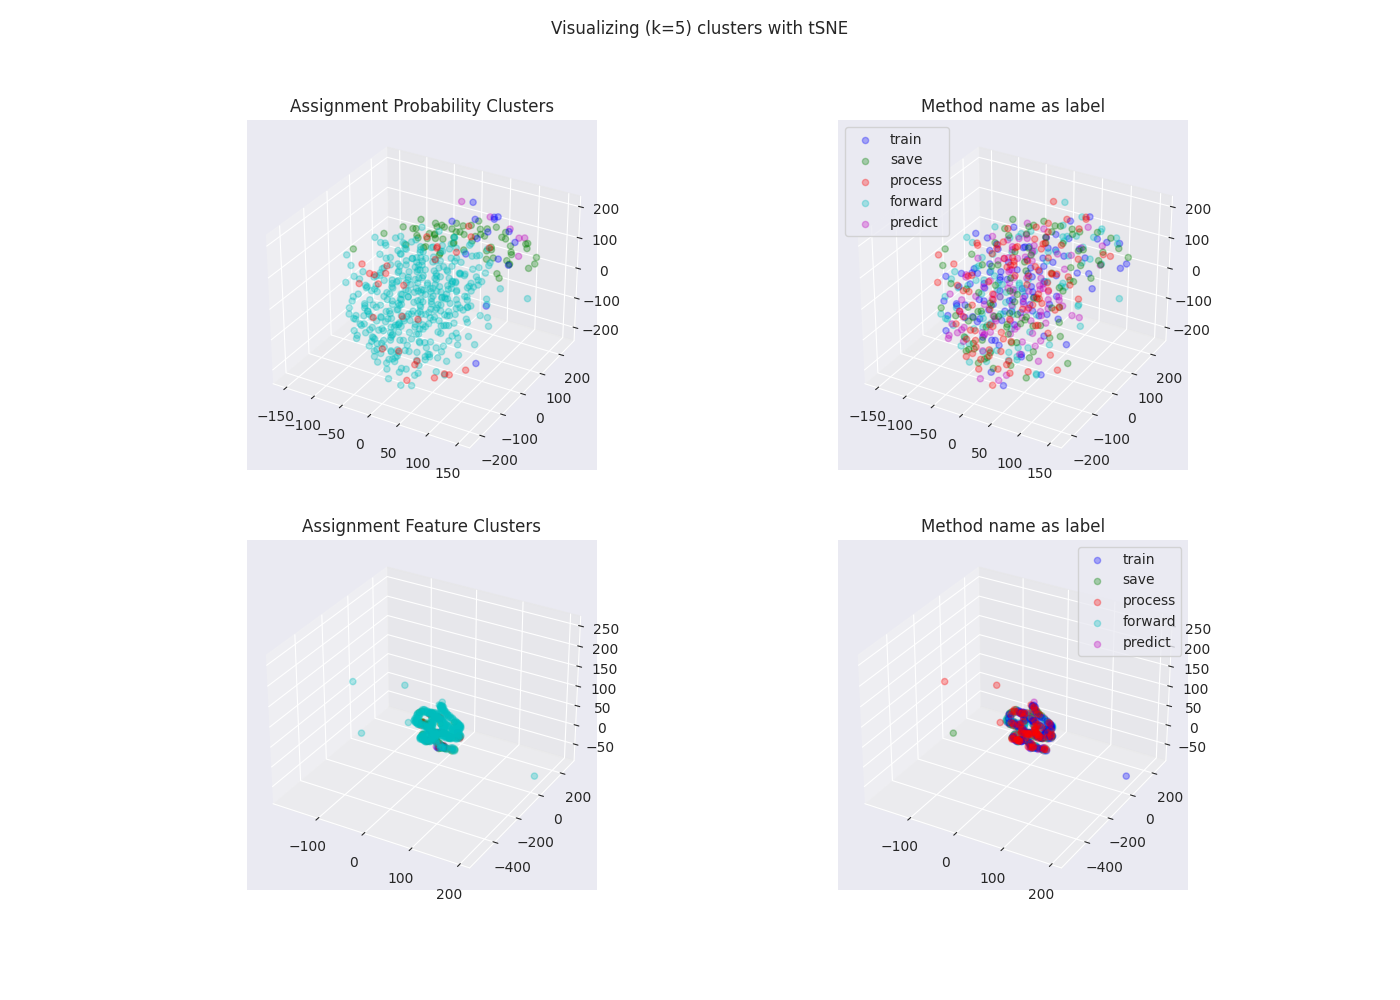

Silhouette Coefficient for Assignment Probabilities: 0.427
Silhouette Coefficient for Assignment Features: 0.486


In [33]:
k = len(classes)

fig = plt.figure(figsize=(14,10))
fig.suptitle(f'Visualizing (k={k}) clusters with tSNE')
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title('Assignment Probability Clusters')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_ap_results[df['cluster_label'] == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=klass)

ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title('Method name as label')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_ap_results[df['method_name_category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
ax2.legend()


ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title('Assignment Feature Clusters')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_af_results[df['cluster_label'] == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=klass)

ax4 = fig.add_subplot(224, projection='3d')
ax4.set_title('Method name as label')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_af_results[df['method_name_category'] == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
ax4.legend()

print("Silhouette Coefficient for Assignment Probabilities: %0.3f"
          % metrics.silhouette_score(assignment_probabilities, df.cluster_label.values, metric='sqeuclidean'))

print("Silhouette Coefficient for Assignment Features: %0.3f"
          % metrics.silhouette_score(assignment_features, df.cluster_label.values, metric='sqeuclidean'))